In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

In [2]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [4]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


## train initial random points

In [5]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x]).unsqueeze(-1)
    train_y = calc_output(train_x)
else:

    train_x = torch.linspace(-5, 5, 5)#.unsqueeze(-1)
    train_y = objective_function(train_x)#.unsqueeze(-1)
    print(train_y)
    
# GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Optimize the model
model.train()
likelihood.train()

for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = - mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    # use EI to find the next point to evaluate
    model.eval()
    likelihood.eval()
    x_candidates = torch.linspace(-5, 5, 100)
    ei = expected_improvement(model, train_y, x_candidates)
    ei_argmax = ei.argmax()
    next_x = x_candidates[ei_argmax]
    next_y = objective_function(next_x).unsqueeze(-1)
    
    # update training points
    train_x = torch.cat([train_x, next_x.unsqueeze(-1)])
    train_y = torch.cat([train_y, next_y])

    model.set_train_data(inputs=train_x, targets=train_y, strict=False)

    

tensor([7.0000, 4.5000, 2.0000, 0.5000, 3.0000])


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [6]:
train_x.shape

torch.Size([55])

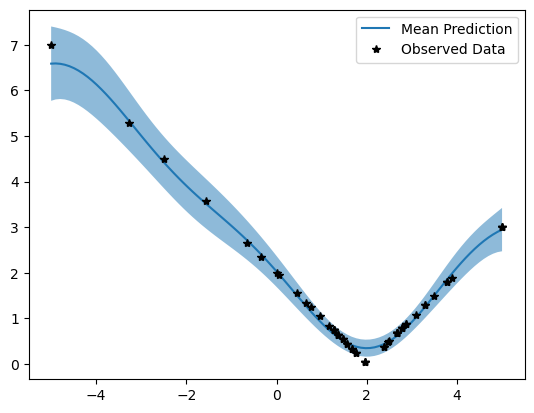

In [7]:
x = torch.linspace(-5, 5, 100)
with torch.no_grad():
    pred = model(x.unsqueeze(-1))
    lower, upper = pred.confidence_region()

plt.plot(x.numpy(), pred.mean.numpy(), label='Mean Prediction')
plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')
plt.legend()
plt.show()

## save model


In [49]:
path = 'models/test_GP.pth'
torch.save(model.state_dict(), path)

## Refresh the kernel (as if opening a new notebook) and load model

In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

In [2]:
def branin(x, y):
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s

def objective_function(x):
    # Objective function with a non-differentiable point at x = 0
    return torch.abs(x - 2)  # Shifted to have a minimum at x = 2


In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [12]:
BRANIN=False
if BRANIN:
    train_x = torch.rand(5,2)
    def calc_output(train_x):
        return torch.tensor([branin(x[0], x[1]) for x in train_x]).unsqueeze(-1)
    train_y = calc_output(train_x)
else:

    train_x = torch.linspace(-5, 5, 50)#.unsqueeze(-1)
    train_y = objective_function(train_x)#.unsqueeze(-1)
    print(train_y)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)
path = 'models/test_GP.pth'
model.load_state_dict(torch.load(path))
model.eval()

tensor([7.0000, 6.7959, 6.5918, 6.3878, 6.1837, 5.9796, 5.7755, 5.5714, 5.3673,
        5.1633, 4.9592, 4.7551, 4.5510, 4.3469, 4.1429, 3.9388, 3.7347, 3.5306,
        3.3265, 3.1224, 2.9184, 2.7143, 2.5102, 2.3061, 2.1020, 1.8980, 1.6939,
        1.4898, 1.2857, 1.0816, 0.8776, 0.6735, 0.4694, 0.2653, 0.0612, 0.1429,
        0.3469, 0.5510, 0.7551, 0.9592, 1.1633, 1.3673, 1.5714, 1.7755, 1.9796,
        2.1837, 2.3878, 2.5918, 2.7959, 3.0000])


GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

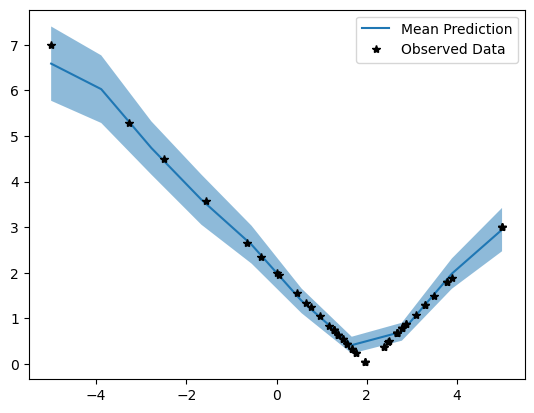

In [8]:
x = torch.linspace(-5, 5, 10)
with torch.no_grad():
    pred = model(x.unsqueeze(-1))
    lower, upper = pred.confidence_region()

plt.plot(x.numpy(), pred.mean.numpy(), label='Mean Prediction')
plt.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')
plt.legend()
plt.show()

In [18]:
pred_mean = pred.mean.numpy()
param = x.numpy()
best_x = param[pred_mean.argmin()]
print(f'minimum of mean value function = {best_x}')
observed_min = train_x[train_y.argmin()]
print(f'observed minimum in data = {observed_min}')

minimum of mean value function = 1.9696969985961914
observed minimum in data = 1.9387754201889038
